<a href="https://colab.research.google.com/github/sumaurya/devtraining-needit-utah/blob/main/Copy_of_EDA_and_Preprocessing_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- read the raw data into a dataframe from merged_master_data.csv

In [1]:
!pip install imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 4.5 MB/s eta 0:00:00


In [2]:
# prompt: read the raw data into a dataframe from merged_master_data.csv

import pandas as pd
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

# Assuming merged_master_data.csv is in the current working directory
original_df = pd.read_csv('merged_master_data.csv')

- drop unwanted columns

In [3]:
# prompt: merge these list.. these are unwanted ciolumns.. drop them
# # skipped 'date' column for now
object_column_names = ['date', 'created_at', 'updated_at', 'annual_earning_date', 'balance_sheet_filing_date', 'cash_flow_filing_date',
                       'earning_history_date', 'exchange_code', 'income_statement_date', 'income_statement_filing_date',
                       'outstanding_shares_date', 'outstanding_shares_date_formatted', 'report_date', 'technical_master_data_sync_date', 'earning_trend_date']
int_column_names = ['id', 'hash_code_value', 'exchange', 'fund', 'vendor', 'vendor_api']

unwanted_columns = object_column_names + int_column_names
modified_df = original_df.drop(columns=unwanted_columns, errors='ignore')

all_target_variables = ['five_percent_reached_in_one_day', 'days_taken_for_5_percent', 'percentage_change_in_next_open']

target_variables=['five_percent_reached_in_one_day']
modified_df = modified_df.drop(columns=['days_taken_for_5_percent', 'percentage_change_in_next_open'])

print("Original DataFrame shape:", original_df.shape)
print("Modified DataFrame shape:", modified_df.shape)

Original DataFrame shape: (11057, 245)
Modified DataFrame shape: (11057, 222)


In [4]:
# prompt: - create a function in which for each column except 'date' column, create column_name+ "_missing" and set it to True if the values was missing/NaN and False if value is present. return the modified dataframe

def create_missing_indicator_columns(df):
  """
  Creates new columns indicating missing values for each column except 'date'.

  Args:
    df: The input pandas DataFrame.

  Returns:
    The modified DataFrame with new missing indicator columns.
  """

  for column in df.columns:
    if column != 'date':
      df[column + '_missing'] = df[column].isnull()

  return df

# Apply the function to the modified_df
modified_df = create_missing_indicator_columns(modified_df)
print("Modified DataFrame shape:", modified_df.shape)

Modified DataFrame shape: (11057, 444)


In [5]:
def convert_to_boolean(df, column_name):
    """
    Converts a column with values 'f' and 't' to boolean values.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the column to convert.
    column_name (str): The name of the column to convert.

    Returns:
    pd.DataFrame: The DataFrame with the specified column converted to boolean.
    """
    if column_name in df.columns:
        df[column_name] = df[column_name].replace({'f': False, 't': True})
        print(f"Converted column '{column_name}' to boolean values.")
    else:
        print(f"Column '{column_name}' does not exist in the DataFrame.")

    return df

# Example usage
modified_df = convert_to_boolean(modified_df, 'five_percent_reached_in_one_day')

Converted column 'five_percent_reached_in_one_day' to boolean values.


- split the dataset into train and test

In [6]:
# prompt: I haven't decided any target variable.. I wanto split the data set as it is into train and test
# - split the dataset into train and test

from sklearn.model_selection import train_test_split

# Split the dataset into train and test sets (e.g., 80% train, 20% test)
train_df, test_df = train_test_split(modified_df, test_size=0.2, random_state=42)

print("Train DataFrame shape:", train_df.shape)
print("Test DataFrame shape:", test_df.shape)

Train DataFrame shape: (8845, 444)
Test DataFrame shape: (2212, 444)


- create a function in which remove duplicate rows from train dataset. return the modified dataframe

In [7]:
# prompt: - create a function in which remove duplicate rows from train dataset. return the modified dataframe

def remove_duplicate_rows(df):
  """
  Removes duplicate rows from a DataFrame.

  Args:
    df: The input pandas DataFrame.

  Returns:
    The modified DataFrame with duplicate rows removed.
  """
  df = df.drop_duplicates()
  return df

# Example usage:
train_df = remove_duplicate_rows(train_df)
print("Train DataFrame shape after removing duplicates:", train_df.shape)

Train DataFrame shape after removing duplicates: (8845, 444)


- create a function in which. and return the modified dataframe
    - for each numeric column in train dataset :
        - apply mutation and fill NaN with median of the same numeric column. if all values in the column are NaN and median can't be calculated, use median 0. keep the non-null values as it is.
        - also store the calculated median should be stored in median_mutation.csv as column_name,meadian_value

In [8]:
# prompt: - create a function in which. and return the modified dataframe
#     - for each numeric column in train dataset :
#         - apply mutation and fill NaN with median of the same numeric column. if all values in the column are NaN and median can't be calculated, use median 0. keep the non-null values as it is.
#         - also store the calculated median should be stored in median_mutation.csv as column_name,meadian_value

def fill_na_with_median_and_store(df):
  """
  Fills NaN values in numeric columns with the median of the column,
  stores the calculated medians in a CSV file, and returns the modified DataFrame.

  Args:
    df: The input pandas DataFrame.

  Returns:
    The modified DataFrame with NaN values filled.
  """
  median_values = {}
  for column in df.select_dtypes(include=['number']):
    median = df[column].median()
    if pd.isnull(median):
      median = 0
    df[column] = df[column].fillna(median)
    median_values[column] = median

  # Store the median values in median_mutation.csv
  median_df = pd.DataFrame(list(median_values.items()), columns=['column_name', 'median_value'])
  median_df.to_csv('median_mutation.csv', index=False)

  return df

# Apply the function to the train_df
train_df = fill_na_with_median_and_store(train_df)
print("Train DataFrame shape after filling NaN with median:", train_df.shape)

Train DataFrame shape after filling NaN with median: (8845, 444)


- create a function in which. and return the modified dataframe
    - for each numeric column in train dataset :
        - check if the distribution is normal using Shapiro-Wilk Test or not and do following action :
            - if normal distribution,
                - if value in current cell is 2 standard deviation away from the mean, then consider it an outlier and replace with a median
                - store (column_name, 2 standard deviation value, median) in outlier_replacement_normal.csv
            - if not normal distribution,
                - do following
                lower_percentile = df['column'].quantile(0.25)
                upper_percentile = df['column'].quantile(0.75)
                df.loc[df['column'] < lower_bound, 'column'] = lower_percentile
                df.loc[df['column'] > upper_bound, 'column'] = upper_percentile
                - store (column_name, lower_percentile value, upper_percentile value) in outlier_replacement_non_normal.csv

In [9]:
# prompt: - create a function in which. and return the modified dataframe
#     - for each numeric column in train dataset :
#         - check if the distribution is normal using Shapiro-Wilk Test or not and do following action :
#             - if normal distribution,
#                 - if value in current cell is 2 standard deviation away from the mean, then consider it an outlier and replace with a median
#                 - store (column_name, 2 standard deviation value, median) in outlier_replacement_normal.csv
#             - if not normal distribution,
#                 - do following
#                 lower_percentile = df['column'].quantile(0.25)
#                 upper_percentile = df['column'].quantile(0.75)
#                 df.loc[df['column'] < lower_bound, 'column'] = lower_percentile
#                 df.loc[df['column'] > upper_bound, 'column'] = upper_percentile
#                 - store (column_name, lower_percentile value, upper_percentile value) in outlier_replacement_non_normal.csv

from scipy.stats import shapiro

def handle_outliers(df):
  """
  Handles outliers in numeric columns based on their distribution (normal or not).

  Args:
    df: The input pandas DataFrame.

  Returns:
    The modified DataFrame with outliers handled.
  """
  outlier_replacement_normal = []
  outlier_replacement_non_normal = []

  for column in df.select_dtypes(include=['number']):
    try:
      # Check for normality using Shapiro-Wilk Test
      stat, p = shapiro(df[column].dropna())
      if p > 0.05:  # Distribution is considered normal
        mean = df[column].mean()
        std = df[column].std()
        upper_bound = mean + 2 * std
        lower_bound = mean - 2 * std
        median = df[column].median()

        df.loc[(df[column] > upper_bound) | (df[column] < lower_bound), column] = median
        outlier_replacement_normal.append((column, 2 * std, median))

      else:  # Distribution is not normal
        lower_percentile = df[column].quantile(0.25)
        upper_percentile = df[column].quantile(0.75)
        df.loc[df[column] < lower_percentile, column] = lower_percentile
        df.loc[df[column] > upper_percentile, column] = upper_percentile
        outlier_replacement_non_normal.append((column, lower_percentile, upper_percentile))
    except Exception as e:
        print(f"Error processing column {column}: {e}")

  # Store outlier replacement information in CSV files
  pd.DataFrame(outlier_replacement_normal, columns=['column_name', '2_std_value', 'median']).to_csv(
      'outlier_replacement_normal.csv', index=False)
  pd.DataFrame(outlier_replacement_non_normal, columns=['column_name', 'lower_percentile', 'upper_percentile']).to_csv(
      'outlier_replacement_non_normal.csv', index=False)

  return df


# Apply the function to the train_df
train_df = handle_outliers(train_df)
print("Train DataFrame shape after handling outliers:", train_df.shape)

Train DataFrame shape after handling outliers: (8845, 444)


- create a function in which. and return the modified dataframe
    - for each column_name in outlier_replacement_normal.csv
        - apply Standardization
    - for each column_name in outlier_replacement_non_normal.csv
        - apply Normalization
    - store the scaler objects in seperate files using joblib

In [10]:
# prompt: - create a function in which. and return the modified dataframe
#     - for each column_name in outlier_replacement_normal.csv
#         - apply Standardization
#     - for each column_name in outlier_replacement_non_normal.csv
#         - apply Normalization
# do it like
# scaler = StandardScaler()
# scaler.fit(train_data[['feature1', 'feature2', ...]])
# not one column at a time

from sklearn.preprocessing import StandardScaler, MinMaxScaler
import joblib

def apply_scaling(df):
  """
  Applies standardization to columns specified in 'outlier_replacement_normal.csv'
  and normalization to columns specified in 'outlier_replacement_non_normal.csv'.

  Args:
    df: The input pandas DataFrame.

  Returns:
    The modified DataFrame with scaling applied.
  """
  try:
    normal_columns = pd.read_csv('outlier_replacement_normal.csv')['column_name'].tolist()
    non_normal_columns = pd.read_csv('outlier_replacement_non_normal.csv')['column_name'].tolist()

    if normal_columns:
      scaler = StandardScaler()
      df[normal_columns] = scaler.fit_transform(df[normal_columns])
      joblib.dump(scaler, 'scaler_normal.joblib')

    if non_normal_columns:
      scaler = MinMaxScaler()
      df[non_normal_columns] = scaler.fit_transform(df[non_normal_columns])
      joblib.dump(scaler, 'scaler_non_normal.joblib')

    return df

  except FileNotFoundError:
    print("Error: 'outlier_replacement_normal.csv' or 'outlier_replacement_non_normal.csv' not found.")
    return df


# Apply the function to the train_df
train_df = apply_scaling(train_df)
print("Train DataFrame shape after scaling:", train_df.shape)

Train DataFrame shape after scaling: (8845, 444)


- apply one-hot encoding. Don't one-hot encode the boolean columns

In [11]:
def apply_one_hot_encoding(df):
    # Identify categorical columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

    for column in categorical_cols:
        if column in df.columns:
            df[column].fillna('Missing', inplace=True)
        else:
            print(f"Column '{column}' does not exist in the DataFrame.")
    # Apply one-hot encoding to categorical columns
    df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    print(categorical_cols)
    print(len(categorical_cols))
    print(df.columns.difference(df_encoded.columns))
    print(df_encoded.columns.difference(df.columns))


    return df_encoded

train_df = apply_one_hot_encoding(train_df)
print(train_df.shape)
print(train_df.info())
train_df.head()

['balance_sheet_currency_symbol', 'before_after_market', 'cash_flow_currency_symbol', 'cash_flow_duration', 'currency_symbol', 'earning_history_currency', 'fund_code', 'income_statement_duration', 'outstanding_shares_duration', 'period']
10
Index(['balance_sheet_currency_symbol', 'before_after_market',
       'cash_flow_currency_symbol', 'cash_flow_duration', 'currency_symbol',
       'earning_history_currency', 'fund_code', 'income_statement_duration',
       'outstanding_shares_duration', 'period'],
      dtype='object')
Index(['balance_sheet_currency_symbol_USD', 'before_after_market_BeforeMarket',
       'before_after_market_Missing', 'cash_flow_currency_symbol_USD',
       'cash_flow_duration_Missing', 'cash_flow_duration_QUARTER',
       'currency_symbol_USD', 'earning_history_currency_USD',
       'income_statement_duration_Missing',
       'income_statement_duration_QUARTER',
       'outstanding_shares_duration_Missing',
       'outstanding_shares_duration_QUARTER', 'period_0y'

,accounts_payable,accumulated_amortization,accumulated_depreciation,accumulated_other_comprehensive_income,additional_paid_in_capital,adjusted_close,adjusted_working_capital,adx,annual_earning_eps_actual,assets,...,cash_flow_duration_Missing,cash_flow_duration_QUARTER,currency_symbol_USD,earning_history_currency_USD,income_statement_duration_Missing,income_statement_duration_QUARTER,outstanding_shares_duration_Missing,outstanding_shares_duration_QUARTER,period_0y,period_Missing
6695,1.000000,0.0,0.0,0.604752,0.0,1.000000,0.0,0.174658,1.000000,0.0,...,False,False,True,True,False,False,False,True,True,False
4065,0.000000,0.0,0.0,0.000000,0.0,0.010551,0.0,0.000000,0.102190,0.0,...,False,True,True,False,False,True,False,False,False,True
7997,0.073948,0.0,0.0,1.000000,0.0,0.193435,0.0,1.000000,0.021898,0.0,...,False,True,True,True,False,True,False,True,False,True
8784,0.000000,0.0,0.0,0.912100,0.0,0.001758,0.0,0.405251,0.102190,0.0,...,False,True,True,True,False,True,False,True,False,True
7277,0.660895,0.0,0.0,1.000000,0.0,0.607855,0.0,0.123288,0.357664,0.0,...,False,True,True,True,False,True,False,False,False,True


- print distribution of five_percent_reached_in_one_day. And Apply resampling(Over/Undersampling) if highly imbalanced.

In [12]:
import pandas as pd

def print_categorical_distribution(df, column_name):
    """
    Print the distribution of a specified categorical column in a DataFrame, including percentages.

    Parameters:
    df (pd.DataFrame): The DataFrame to inspect.
    column_name (str): The name of the column to display.

    Returns:
    None
    """
    if column_name in df.columns:
        # Calculate value counts and percentages
        value_counts = df[column_name].value_counts()
        percentages = df[column_name].value_counts(normalize=True) * 100

        # Combine counts and percentages into a DataFrame
        distribution_df = pd.DataFrame({
            'Count': value_counts,
            'Percentage': percentages
        })

        print(f'Distribution of {column_name}:')
        print(distribution_df)
    else:
        print(f"Column '{column_name}' does not exist in the DataFrame.")

# Example usage
print_categorical_distribution(train_df, 'five_percent_reached_in_one_day')


Distribution of five_percent_reached_in_one_day:
                                 Count  Percentage
five_percent_reached_in_one_day                   
False                             8677   98.100622
True                               168    1.899378


In [13]:
# prompt: write a function to apply oversampling and return train_df

from imblearn.over_sampling import RandomOverSampler

def apply_oversampling(train_df):
  """
  Applies oversampling to the training data if the target variable is highly imbalanced.

  Args:
    train_df: The input training DataFrame.

  Returns:
    The modified DataFrame with oversampling applied.
  """

  X = train_df.drop('five_percent_reached_in_one_day', axis=1)
  y = train_df['five_percent_reached_in_one_day']

  ros = RandomOverSampler(random_state=42)
  X_resampled, y_resampled = ros.fit_resample(X, y)

  train_df_resampled = pd.concat([X_resampled, y_resampled], axis=1)
  return train_df_resampled


# Apply oversampling
# train_df = apply_oversampling(train_df)
print("Train DataFrame shape after oversampling:", train_df.shape)
print_categorical_distribution(train_df, 'five_percent_reached_in_one_day')

Train DataFrame shape after oversampling: (8845, 448)
Distribution of five_percent_reached_in_one_day:
                                 Count  Percentage
five_percent_reached_in_one_day                   
False                             8677   98.100622
True                               168    1.899378


- Reduce Dimensions(remove multicolinearity). Apply PCA.

In [14]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def find_ideal_component_count(train_df, target_variables) :
  # Assuming X_scaled is your standardized data
  X_scaled = train_df.drop(columns=target_variables)
  pca = PCA().fit(X_scaled)

  # Get explained variance ratio
  explained_variance = pca.explained_variance_ratio_

  # Filter for values greater than 0
  positive_variance = explained_variance[explained_variance > 0]

  # Count components with explained variance greater than 0
  count_positive_components = len(positive_variance)

  # Print count of components
  print(f"Count of components where explained_variance_ratio > 0: {count_positive_components}")

  # Plotting the positive explained variance ratio
  plt.figure(figsize=(8, 5))
  plt.bar(range(1, len(positive_variance) + 1), positive_variance)
  plt.title('PCA Explained Variance Ratio (Only Positive Values)')
  plt.xlabel('Principal Component')
  plt.ylabel('Explained Variance Ratio')
  plt.xticks(range(1, len(positive_variance) + 1))
  plt.show()

  return count_positive_components

# train_df.head()

Count of components where explained_variance_ratio > 0: 296


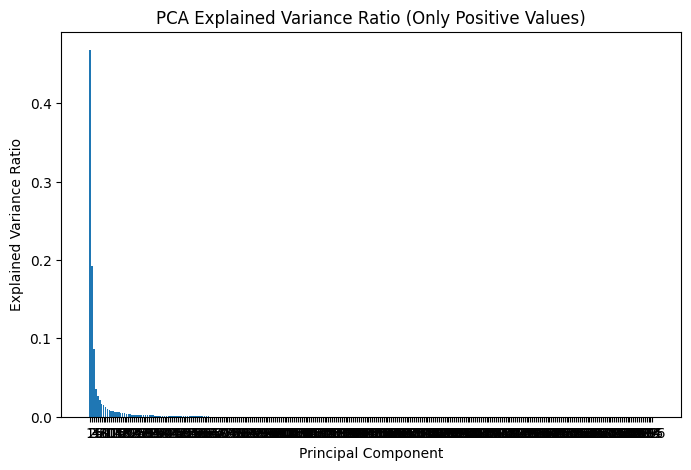

In [15]:
n_components = find_ideal_component_count(train_df, target_variables)

In [16]:
import numpy as np
def apply_pca(train_df, n_components=None, target_variables=[]):
    # Step 1: Separate input variables and target variables
    X = train_df.drop(columns=target_variables)  # Input variables
    y = train_df[target_variables]  # Target variables

    # Step 2: Apply PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)  # Fit and transform the input variables

    # Step 3: Create a DataFrame from PCA results
    X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

    # Step 4: Combine PCA results with target variables
    modified_train_df = pd.concat([X_pca_df, y.reset_index(drop=True)], axis=1)
    joblib.dump(pca, 'pca.joblib')

    # Get explained variance ratio
    explained_variance_ratio = pca.explained_variance_ratio_

    return pd.DataFrame(modified_train_df), explained_variance_ratio

# Apply PCA
transformed_df, variance_ratio = apply_pca(train_df, n_components, target_variables)

# Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(variance_ratio)
cumulative_n = cumulative_explained_variance[:n_components]

# Print results
# print("\nExplained Variance Ratio:")
# print(variance_ratio)
# print("\nCumulative Explained Variance Ratio:")
# print(cumulative_n)
print("\ntransformed_df shape:")
print(transformed_df.shape)
print("Transformed Data:")
transformed_df.head()



transformed_df shape:
(8845, 297)
Transformed Data:


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC288,PC289,PC290,PC291,PC292,PC293,PC294,PC295,PC296,five_percent_reached_in_one_day
0,-7.453150,2.470134,1.105248,-0.508128,-1.018365,0.547383,0.744066,0.782505,-0.478948,-0.880079,...,-1.616297e-16,-9.056629e-17,-1.786499e-16,1.179276e-16,-2.083710e-17,-1.885116e-17,2.707103e-16,1.645354e-16,5.708105e-31,False
1,2.868944,-1.585112,1.999649,1.969252,1.083133,0.474812,1.796872,0.313725,0.521508,0.085501,...,-2.171409e-16,-5.934127e-17,-2.168138e-16,2.966041e-16,-2.845151e-16,-7.436231e-17,4.372437e-16,2.755577e-16,-1.872355e-31,False
2,0.522643,-3.101179,-1.577743,-1.911463,0.834713,0.993579,0.287629,0.228500,0.693659,0.788742,...,-1.616297e-16,-5.543814e-17,-1.387512e-16,3.052777e-16,-1.387983e-16,2.972110e-17,3.782631e-16,2.478022e-16,-1.764957e-30,False
3,2.357011,-2.521601,1.705124,0.827168,0.183438,0.231224,1.064085,-0.799609,-0.499813,0.112649,...,-2.726520e-16,-1.664604e-16,-1.387512e-16,2.497666e-16,-1.387983e-16,2.972110e-17,4.892854e-16,2.755577e-16,-1.872355e-31,False
4,-3.477878,-1.219283,-3.601614,0.220856,0.441902,0.814220,0.563063,-0.507720,1.268112,-0.540560,...,-1.616297e-16,-1.105156e-16,-1.821193e-16,1.491526e-16,-2.567595e-16,8.904414e-18,3.123436e-16,2.165772e-16,7.865147e-31,False


In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_input_target_correlation_heatmap(df, target_variables):
    """
    Plots the correlation heatmap of input variables against target variables.

    Parameters:
    df (pd.DataFrame): The DataFrame containing input and target variables.
    target_variables (list): List of target variable names.

    Returns:
    None
    """
    # Separate input and target variables
    input_variables = df.drop(columns=target_variables)

    # Calculate correlation matrix only for input and target variables
    correlation_matrix = df[input_variables.columns.tolist() + target_variables].corr()

    # Filter the correlation matrix to show only input vs target
    input_target_corr = correlation_matrix.loc[input_variables.columns, target_variables]

    # Set up the matplotlib figure
    plt.figure(figsize=(10, 6))

    # Create the heatmap
    sns.heatmap(input_target_corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

    # Set labels and title
    plt.title('Correlation Heatmap: Input Variables vs Target Variables')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    # Show the heatmap
    plt.tight_layout()
    plt.show()

# plot_correlation_heatmap(transformed_df, target_variables)

- Prepare test data

- fill NA in test data

In [18]:
def fill_na_in_test_data(test_df, target_variables):
  # Load the median mutation data
  median_mutation_df = pd.read_csv('median_mutation.csv')

  null_counts = test_df.isna().sum()
  # Get the column names where the count of nulls is greater than 0
  columns_with_nulls = null_counts[null_counts > 0].index.tolist()
  # Print the column names
  # print("Columns with null values before:", len(columns_with_nulls))

  for index, row in median_mutation_df.iterrows():
      column_name = row['column_name']
      median_value = row['median_value']

      # Check if the column exists in test_df
      if column_name in test_df.columns:
          # Replace null values in the specified column with the median_value
          test_df[column_name].fillna(median_value, inplace=True)

  null_counts = test_df.isna().sum()
  # Get the column names where the count of nulls is greater than 0
  columns_with_nulls = null_counts[null_counts > 0].index.tolist()
  # Print the column names
  # print("Columns with null values:", len(columns_with_nulls))

  return test_df

- handle outliers

In [19]:
def replace_outliers_test_data(test_df, normal_file, non_normal_file):
    # Load the outlier replacement data
    normal_df = pd.read_csv(normal_file)
    non_normal_df = pd.read_csv(non_normal_file)

    # Initialize a list to keep track of mutated columns
    mutated_columns = []

    # Process normal distribution outliers
    for index, row in normal_df.iterrows():
        column_name = row['column_name']
        std_value = row['2_std_value']
        median_value = row['median']

        if column_name in test_df.columns:
            # Identify outliers
            outliers = test_df[column_name].abs() > std_value

            # Replace outliers with median
            if outliers.any():
                test_df.loc[outliers, column_name] = median_value
                mutated_columns.append(column_name)

    # Process non-normal distribution outliers
    for index, row in non_normal_df.iterrows():
        column_name = row['column_name']
        lower_percentile = row['lower_percentile']
        upper_percentile = row['upper_percentile']

        if column_name in test_df.columns:
            # Replace values below lower_percentile
            below_lower = test_df[column_name] < lower_percentile
            if below_lower.any():
                test_df.loc[below_lower, column_name] = lower_percentile
                mutated_columns.append(column_name)

            # Replace values above upper_percentile
            above_upper = test_df[column_name] > upper_percentile
            if above_upper.any():
                test_df.loc[above_upper, column_name] = upper_percentile
                mutated_columns.append(column_name)

    # Print the mutated column names
    print("Columns where values were mutated:", mutated_columns)

    return test_df

- Apply Scaling on test data

In [20]:
def apply_scaling_on_test_data(df):
  try:
    normal_columns = pd.read_csv('outlier_replacement_normal.csv')['column_name'].tolist()
    non_normal_columns = pd.read_csv('outlier_replacement_non_normal.csv')['column_name'].tolist()

    if normal_columns:
      scaler = joblib.load('scaler_normal.joblib')
      df[normal_columns] = scaler.transform(df[normal_columns])

    if non_normal_columns:
      scaler = joblib.load('scaler_non_normal.joblib')
      df[non_normal_columns] = scaler.transform(df[non_normal_columns])

    return df

  except FileNotFoundError:
    print("Error: 'outlier_replacement_normal.csv' or 'outlier_replacement_non_normal.csv' not found.")
    return df

- apply PCA on test data

In [21]:
def apply_pca_on_test_data(test_df, n_components=None, target_variables=[]):
    # Step 1: Separate input variables and target variables
    X = test_df.drop(columns=target_variables)  # Input variables
    y = test_df[target_variables]  # Target variables

    # Step 2: Apply PCA
    pca = joblib.load('pca.joblib')
    X_pca = pca.transform(X)  # transform the input variables

    # Step 3: Create a DataFrame from PCA results
    X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

    # Step 4: Combine PCA results with target variables
    modified_test_df = pd.concat([X_pca_df, y.reset_index(drop=True)], axis=1)

    # Get explained variance ratio
    explained_variance_ratio = pca.explained_variance_ratio_

    return pd.DataFrame(modified_test_df), explained_variance_ratio

In [22]:
def prepare_test_data(test_df, target_variables):

  # Apply the function to the test_df
  test_df = fill_na_in_test_data(test_df, target_variables)
  test_df = replace_outliers_test_data(test_df, 'outlier_replacement_normal.csv', 'outlier_replacement_non_normal.csv')
  test_df = apply_scaling_on_test_data(test_df)
  test_df = apply_one_hot_encoding(test_df)
  test_df, explained_variance_ratio = apply_pca_on_test_data(test_df, n_components, target_variables)
  print("Test DataFrame shape after preparing:", test_df.shape)
  return test_df

test_df = prepare_test_data(test_df, target_variables)
test_df.head()

Columns where values were mutated: ['accounts_payable', 'accounts_payable', 'accumulated_depreciation', 'accumulated_depreciation', 'accumulated_other_comprehensive_income', 'accumulated_other_comprehensive_income', 'adjusted_close', 'adjusted_close', 'adx', 'adx', 'annual_earning_eps_actual', 'annual_earning_eps_actual', 'atr', 'atr', 'avgvol', 'avgvol', 'avgvolccy', 'avgvolccy', 'begin_period_cash_flow', 'begin_period_cash_flow', 'beta', 'beta', 'capital_expenditures', 'capital_expenditures', 'capital_lease_obligations', 'capital_lease_obligations', 'capital_stock', 'capital_stock', 'capital_surpluse', 'capital_surpluse', 'cash', 'cash', 'cash_and_cash_equivalents_changes', 'cash_and_cash_equivalents_changes', 'cash_and_equivalents', 'cash_and_equivalents', 'cash_and_short_term_investments', 'cash_and_short_term_investments', 'cash_flow_net_income', 'cash_flow_net_income', 'cash_flows_other_operating', 'cash_flows_other_operating', 'cci', 'cci', 'change_in_cash', 'change_in_cash', 'c

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC288,PC289,PC290,PC291,PC292,PC293,PC294,PC295,PC296,five_percent_reached_in_one_day
0,-7.086965,1.715389,-0.175406,-0.232148,1.781496,-0.876858,-0.396510,0.857796,-0.369762,-0.551104,...,-2.865298e-16,-1.321997e-16,-3.987201e-17,1.717040e-16,-2.845151e-16,2.972110e-17,2.082602e-16,2.339244e-16,6.139513e-31,False
1,2.893311,-1.731745,2.143529,2.133294,0.875304,-0.630835,0.068830,0.856267,0.760846,-0.088153,...,-2.171409e-16,-5.934127e-17,-2.168138e-16,2.966041e-16,-2.845151e-16,-7.436231e-17,4.372437e-16,2.755577e-16,-1.872355e-31,False
2,-0.097925,-2.540857,-1.737053,-1.488644,0.817131,0.525357,0.197689,-0.163478,0.935619,1.139613,...,-1.061186e-16,-1.035767e-16,-1.543638e-16,2.185416e-16,-1.596150e-16,6.441557e-17,1.180546e-16,2.478022e-16,-1.872355e-31,False
3,-5.030120,2.413458,3.466146,-0.806230,0.447432,0.506803,-0.449576,-0.993864,1.469185,3.189661,...,-2.310187e-16,-1.252608e-16,-1.370165e-16,1.717040e-16,-1.873706e-16,8.523225e-17,4.615298e-16,1.784132e-16,-3.536359e-31,False
4,2.863178,-1.567483,2.024237,2.078822,1.019810,-0.100797,0.888023,0.630584,0.904488,0.029740,...,-2.171409e-16,-5.934127e-17,-2.168138e-16,2.966041e-16,-2.845151e-16,-7.436231e-17,4.372437e-16,2.755577e-16,-1.872355e-31,False


In [28]:
import numpy as np
import time
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                              HistGradientBoostingClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report

def custom_class_weights(y):
    class_counts = y.value_counts()
    total_samples = len(y)
    num_classes = len(class_counts)
    return {cls: total_samples / (num_classes * count) for cls, count in class_counts.items()}

def adjust_class_weights(y_true, current_weights, y_pred, threshold):
    cm = confusion_matrix(y_true, (y_pred > threshold).astype(int))
    TP = cm[1, 1] if cm.shape[0] > 1 else 0
    FP = cm[0, 1] if cm.shape[0] > 1 else 0

    if TP > 0:
        ratio = FP / TP
        if ratio >= 0.33:
            new_weights = {
                0: 1,
                1: current_weights[1] ** (1 + (ratio - 0.33))
            }
            return new_weights
    return current_weights

def evaluate_model(X_train, y_train, X_test, y_test, epochs=3, thresholds=np.arange(0.1, 1.0, 0.1)):
    classifiers = {
        "Logistic Regression": LogisticRegression(),
        "Decision Tree": DecisionTreeClassifier(),
        "Random Forest": RandomForestClassifier(),
        "Support Vector Machine": SVC(probability=True),
        "K-Nearest Neighbors": KNeighborsClassifier(),
        "Hist Gradient Boosting": HistGradientBoostingClassifier(),
        "Gradient Boosting": GradientBoostingClassifier()
    }

    # Define initial class weights
    initial_weights = custom_class_weights(y_train)

    # Define hyperparameter grids
    param_grid = {
        "Logistic Regression": {
            'class_weight': ['balanced', initial_weights, None],
            'C': [0.01, 0.1, 1, 10, 100],
            'solver': ['liblinear', 'saga']
        },
        "Decision Tree": {
            'class_weight': ['balanced', initial_weights, None],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10]
        },
        "Random Forest": {
            'class_weight': ['balanced', initial_weights, None],
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5]
        },
        "Support Vector Machine": {
            'class_weight': ['balanced', initial_weights, None],
            'C': [0.1, 1, 10],
            'gamma': ['scale', 'auto']
        },
        "K-Nearest Neighbors": {
            'n_neighbors': [3, 5, 7, 10],
            'weights': ['uniform', 'distance']
        },
        "Hist Gradient Boosting": {
            'class_weight': ['balanced', initial_weights, None],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5]
        },
        "Gradient Boosting": {
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5]
        }
    }

    for name, model in classifiers.items():
        print(f"Starting evaluation for {name}...")
        start_time = time.time()

        # Set initial class weights
        model.set_params(class_weight=initial_weights)

        for threshold in thresholds:
            print(f"Evaluating at threshold {threshold:.1f} for {name}...")
            threshold_start_time = time.time()

            current_weights = initial_weights.copy()  # Start with initial weights for this threshold

            for epoch in range(epochs):
                print(f"  Epoch {epoch + 1} for {name}:")
                epoch_start_time = time.time()

                # Use GridSearchCV for hyperparameter tuning
                grid_search = GridSearchCV(model, param_grid[name], cv=5, scoring='f1')
                grid_search.fit(X_train, y_train)
                y_pred_proba = grid_search.predict_proba(X_train)[:, 1]  # Get probabilities

                # Adjust class weights based on predictions
                current_weights = adjust_class_weights(y_train, current_weights, y_pred_proba, threshold)
                model.set_params(class_weight=current_weights)

                epoch_end_time = time.time()
                print(f"  Time taken for epoch {epoch + 1}: {epoch_end_time - epoch_start_time:.2f} seconds")

            # Final predictions on test data at the current threshold
            y_test_pred_proba = grid_search.predict_proba(X_test)[:, 1]
            y_test_pred = (y_test_pred_proba > threshold).astype(int)
            cm = confusion_matrix(y_test, y_test_pred)
            report = classification_report(y_test, y_test_pred)

            TP = cm[1, 1]
            FP = cm[0, 1]

            print(f"{name} - Best params: {grid_search.best_params_} at threshold {threshold:.1f}")
            print(f"Final class weights: {current_weights}")
            print(f"Confusion Matrix:\n{cm}")
            print(f"Classification Report:\n{report}\n")

            threshold_end_time = time.time()
            print(f"Time taken for threshold {threshold:.1f}: {threshold_end_time - threshold_start_time:.2f} seconds")

        end_time = time.time()
        print(f"Total time taken for {name}: {end_time - start_time:.2f} seconds\n")

# Usage
# evaluate_model(X_train, y_train, X_test, y_test)


In [ ]:
# Split the data into features (X) and target (y)
X_train = transformed_df.drop('five_percent_reached_in_one_day', axis=1)
y_train = transformed_df['five_percent_reached_in_one_day']
X_test = test_df.drop('five_percent_reached_in_one_day', axis=1)
y_test = test_df['five_percent_reached_in_one_day']

evaluate_model(X_train, y_train, X_test, y_test)

Starting evaluation for Logistic Regression...
Epoch 1 for Logistic Regression:
Time taken for epoch 1: 363.92 seconds
Epoch 2 for Logistic Regression:
Time taken for epoch 2: 360.84 seconds
Epoch 3 for Logistic Regression:
Time taken for epoch 3: 361.08 seconds
Logistic Regression - Best params: {'C': 100, 'class_weight': 'balanced', 'solver': 'liblinear'} at threshold 0.1
Final class weights: {0: 1, 1: 1.737235246096033e+21}
Confusion Matrix:
[[1186  984]
 [   6   36]]
Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.55      0.71      2170
        True       0.04      0.86      0.07        42

    accuracy                           0.55      2212
   macro avg       0.52      0.70      0.39      2212
weighted avg       0.98      0.55      0.69      2212


Time taken for threshold 0.1: 0.01 seconds
Logistic Regression - Best params: {'C': 100, 'class_weight': 'balanced', 'solver': 'liblinear'} at threshold 0.2
Final class weig

Current runtime : 1h40m

# - **Neural Network**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

# Define the neural network model
def create_model(optimizer='adam', neurons=[128, 64, 32, 16]):
    model = keras.Sequential()
    model.add(layers.InputLayer(input_shape=(300,)))  # 300 input features

    for n in neurons:
        model.add(layers.Dense(n, activation='relu'))

    model.add(layers.Dense(1, activation='sigmoid'))  # Binary output
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[keras.metrics.Precision(name='precision'), keras.metrics.Recall(name='recall')])
    return model

# Function to adjust class weights dynamically
def adjust_class_weights(fp, tp, initial_weights):
    if tp > 0:
        ratio = fp / tp
        if ratio >= 0.33:
            adjusted_weight = initial_weights[1] ** (1 + (ratio - 0.33))
            class_weights = {0: initial_weights[0], 1: adjusted_weight}
        else:
            class_weights = initial_weights
    else:
        class_weights = initial_weights

    return class_weights

# Custom callback to update class weights based on FP/TP ratio
def custom_callback(epoch, model, X_val, y_val, initial_weights):
    y_pred_proba = model.predict(X_val)
    cm = confusion_matrix(y_val, (y_pred_proba > 0.5).astype(int))
    TP = cm[1, 1] if cm.shape[0] > 1 else 0
    FP = cm[0, 1] if cm.shape[0] > 1 else 0

    # Adjust class weights based on FP/TP ratio
    class_weights = adjust_class_weights(FP, TP, initial_weights)

    print(f"Epoch {epoch + 1}: TP={TP}, FP={FP}, FP/TP={FP/TP:.2f} (if TP > 0), Adjusted Class Weights: {class_weights}")

    # Update the model's class weights for the next training iteration
    model.set_params(class_weight=class_weights)

# Set up the data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Initial class weights
initial_weights = {0: 1.0, 1: 1.0}

# Define the KerasClassifier
model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=10, verbose=0)

# Define the hyperparameter grid
param_grid = {
    'neurons': [[128, 64, 32, 16]],  # Configuration for hidden layers
    'optimizer': ['adam', 'sgd'],
    'batch_size': [10, 20, 30]
}

# Set up GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1', cv=3)

# Fit the model with a custom training loop
def fit_model_with_callback(grid, X_train, y_train, X_val, y_val, initial_weights, thresholds):
    best_score = 0
    best_params = {}

    for params in grid.param_grid:
        model.set_params(**params)
        for epoch in range(1, grid.n_iter_ + 1):
            model.fit(X_train, y_train, validation_data=(X_val, y_val), class_weight=initial_weights, epochs=1, verbose=0)
            custom_callback(epoch, model, X_val, y_val, initial_weights)

        # Predict probabilities for validation set
        y_val_pred_proba = model.predict(X_val)

        # Evaluate based on thresholds
        for threshold in thresholds:
            y_val_pred = (y_val_pred_proba > threshold).astype(int)
            score = f1_score(y_val, y_val_pred)  # Use F1 score

            if score > best_score:
                best_score = score
                best_params = params

            cm = confusion_matrix(y_val, y_val_pred)
            TP = cm[1, 1] if cm.shape[0] > 1 else 0
            FP = cm[0, 1] if cm.shape[0] > 1 else 0
            print(f"Threshold: {threshold:.1f}, TP={TP}, FP={FP}, FP/TP={FP/TP:.2f} (if TP > 0)")

    return best_params, best_score

# Define thresholds to evaluate
thresholds = np.arange(0.1, 1.0, 0.1)

best_params, best_score = fit_model_with_callback(grid, X_train, y_train, X_val, y_val, initial_weights, thresholds)

print(f"Best parameters: {best_params}")
print(f"Best F1 score: {best_score}")

# Final evaluation on the test set
y_test_pred_proba = model.predict_proba(X_test)[:, 1]

# Evaluate on all thresholds and print confusion matrix and classification report
for threshold in thresholds:
    y_test_pred = (y_test_pred_proba > threshold).astype(int)
    cm = confusion_matrix(y_test, y_test_pred)
    report = classification_report(y_test, y_test_pred)

    print(f"Threshold: {threshold:.1f}")
    print("Confusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(report)
